In [2]:
SEED = 202


# std libs
import glob

# num libs
import math
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)

import cv2

In [3]:
##   cylindrial projection
SURROUND_U_STEP = 1.    #resolution
SURROUND_V_STEP = 1.33
SURROUND_U_MIN, SURROUND_U_MAX = np.array([0,    360])/SURROUND_U_STEP  # horizontal of cylindrial projection
SURROUND_V_MIN, SURROUND_V_MAX = np.array([-90,   90])/SURROUND_V_STEP  # vertical   of cylindrial projection


In [22]:
def lidar_to_surround_coords_360(x, y, z, d ):
    u =   np.arctan2(x, y)/np.pi*360 /SURROUND_U_STEP
    v = - np.arctan2(z, d)/np.pi*360 /SURROUND_V_STEP
    u = (u +90)%360  ##<todo> car will be spit into 2 at boundary  ...

    u = np.rint(u)
    v = np.rint(v)
    u = (u - SURROUND_U_MIN).astype(np.uint8)
    v = (v - SURROUND_V_MIN).astype(np.uint8)

    return u,v


In [4]:
def lidar_to_surround_coords_180(x, y, z, d ):
    u =   np.arctan2(x, y)/np.pi*180 /SURROUND_U_STEP
    v = - np.arctan2(z, d)/np.pi*180 /SURROUND_V_STEP
    u = (u +90)%360  ##<todo> car will be spit into 2 at boundary  ...

    u = np.rint(u)
    v = np.rint(v)
    u = (u - SURROUND_U_MIN).astype(np.uint8)
    v = (v - SURROUND_V_MIN).astype(np.uint8)

    return u,v


In [23]:
def lidar_to_surround(lidar):
    def normalise_to_255(a):
        return (((a - min(a)) / float(max(a) - min(a))) * 255).astype(np.uint8)

    x = lidar['x']
    y = lidar['y']
    z = lidar['z']
    r = lidar['intensity']
    d = np.sqrt(x ** 2 + y ** 2)  # map distance relative to origin
    #u,v = lidar_to_surround_coords(x,y,z,d)
    u,v = lidar_to_surround_coords_360(x,y,z,d)

    width  = int(SURROUND_U_MAX - SURROUND_U_MIN + 1)
    height = int(SURROUND_V_MAX - SURROUND_V_MIN + 1)
    surround     = np.zeros((height, width, 3), dtype=np.float32)
    surround_img = np.zeros((height, width, 3), dtype=np.uint8)

    surround[v, u, 0] = d
    surround[v, u, 1] = z
    surround[v, u, 2] = r
    surround_img[v, u, 0] = normalise_to_255(np.clip(d,     0, 30))
    surround_img[v, u, 1] = normalise_to_255(np.clip(z+1.8, 0, 100))
    surround_img[v, u, 2] = normalise_to_255(np.clip(r,     0, 30))

    return surround, surround_img

In [6]:
# drawing ####
def box3d_to_surround_box(boxes3d):
    is_reshape = boxes3d.shape==(8,3) #support for single box3d

    if is_reshape:
        boxes3d = boxes3d.reshape(1,8,3)

    num = len(boxes3d)
    surround_boxes = np.zeros((num,4),  dtype=np.float32)
    for n in range(num):
        b = boxes3d[n]

        x = b[:,0]
        y = b[:,1]
        z = b[:,2]
        d = np.sqrt(x ** 2 + y ** 2)
        u,v = lidar_to_surround_coords(x,y,z,d)
        umin,umax = np.min(u),np.max(u)
        vmin,vmax = np.min(v),np.max(v)
        surround_boxes[n] = np.array([umin,vmin,umax,vmax])

    if is_reshape:
        surround_boxes = surround_boxes.squeeze()

    return surround_boxes

In [7]:
def draw_box3d_on_surround(image, boxes3d, color=(255,255,255)):

    surround_boxes = box3d_to_surround_box(boxes3d)
    is_reshape = surround_boxes.shape==(4)
    if is_reshape:
        surround_boxes = surround_boxes.reshape(1,4)

    num = len(surround_boxes)
    for n in range(num):
        b = surround_boxes[n]
        x1,y1,x2,y2  = b
        cv2.rectangle(image,(x1,y1),(x2,y2),color,1,cv2.LINE_AA)

In [9]:
lidar_dir = './npy'

In [13]:
lidar_file = './npy/1530509312596502000.npy'

In [14]:
lidar = np.load(lidar_file)

In [16]:
type(lidar)

numpy.ndarray

In [17]:
surround, surround_img = lidar_to_surround(lidar)

In [18]:
surround_img_file = '1530509312596502000.png'

In [24]:
cv2.imwrite(surround_img_file,surround_img)

True

In [20]:
!ls -l

total 36
-rw-r--r-- 1 root     root     6516 Dec  3 06:46 1530509312596502000.png
-rw-r--r-- 1 root     root     1472 Dec  3 06:38 Untitled.ipynb
-rw-rw-r-- 1 adioshun adioshun    0 Dec  3 06:17 main.py
drwxr-xr-x 2 root     root     4096 Dec  3 06:42 npy
-rw-rw-r-- 1 adioshun adioshun 4173 Dec  3 06:42 run_dump_lidar.py
-rw-r--r-- 1 root     root     7235 Dec  3 06:46 surround_view.ipynb


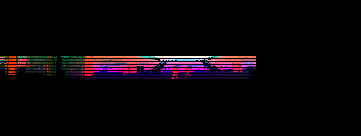

In [25]:
from IPython.display import Image
Image(filename='1530509312596502000.png') 

In [3]:
!jupyter nbconvert --to html --template basic surround_view.ipynb

[NbConvertApp] Converting notebook surround_view.ipynb to html
[NbConvertApp] Writing 39162 bytes to surround_view.html


In [4]:
!jupyter nbconvert --to html surround_view.ipynb

[NbConvertApp] Converting notebook surround_view.ipynb to html
[NbConvertApp] Writing 312481 bytes to surround_view.html


In [6]:
!wget https://gist.githubusercontent.com/frankcleary/bf7a63680a1945942195/raw/9d82e5aedb102c3fe11f7d9ded90d83b1839961f/web.tpl

--2018-12-03 10:47:45--  https://gist.githubusercontent.com/frankcleary/bf7a63680a1945942195/raw/9d82e5aedb102c3fe11f7d9ded90d83b1839961f/web.tpl
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.72.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.72.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1716 (1.7K) [text/plain]
Saving to: 'web.tpl'

web.tpl             100%[===================>]   1.68K  --.-KB/s    in 0s      

2018-12-03 10:47:45 (197 MB/s) - 'web.tpl' saved [1716/1716]



In [7]:
!jupyter nbconvert --to html --template ./web surround_view.ipynb

[NbConvertApp] Converting notebook surround_view.ipynb to html
[NbConvertApp] Writing 312759 bytes to surround_view.html


In [8]:
!jupyter nbconvert --to html --template ./web123 surround_view.ipynb

[NbConvertApp] Converting notebook surround_view.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 11, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/application.py", line 266, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 337, in start
    self.convert_notebooks()
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 507, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python2.7/dist-packages/nbconvert/nbconvertapp.py", line 478, in convert_single_notebook
    output, resources = self.export_single_notebook(notebook_filename, resources, input_buffer=input_buffer)
  File "/usr